In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Business 

* As we are interested only in restaurants, we are going to focus our EDA on a subset of the business dataset.
* Need to decide the following: 
    * Should we focus on a specific city or state? 
    * What data cleaning procedures are needed? 
        * Some people reviewed the same restaurant more than once 

## Initial Insights
### Entire Business Dataset  
* Businesses from 27 different states are included with the top three states being PA, FL, and TN
    * PA:    34039
    * FL:     26330
    * TN:     12056
* A vast majority of the reviews from PA comes from Philadelphia (14567), which is expected
* Top 3 Cities: 
    * Philadelphia      14569
    * Tucson             9250
    * Tampa              9050 

### Restaurant Subset 
* Greatest number of restaurants are also in Philedelphia however the number of reviews per restaurant is highest in New Orleans 
* A vast majority of restaurants in New Orleans have between 1-250 reviews with the max number of reviews being 7568 and the minimum number of reviews being 5. 

In [34]:
path = '/Users/shafz/OneDrive/Documents/machine-learning-dse-i210-final-project-yelprestaurantrecommender/data/raw/'
business = pd.read_csv(path+'raw_business.csv')
#business.head(5)

* The attributes column contains characteresitics of the business, which allows us to filter out the restaurants by looking at the tags

In [35]:
restaurants = business[business.categories.fillna('-').str.lower().str.contains('restaurant')]
#restaurants.head(5)

In [ ]:
# print('Restaurants shape: ', restaurants.shape)
# print('Columns: ', restaurants.columns)
# print('Dtype: ', restaurants.dtypes)

In [ ]:
#restaurants.info(show_counts=True)

In [ ]:
#restaurants.describe()

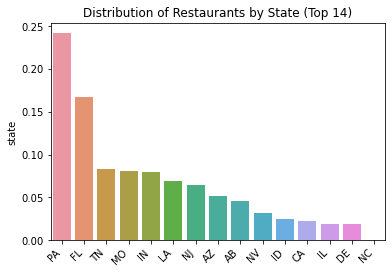

In [36]:
sns.barplot(x=restaurants['state'].value_counts().index.tolist()[:15], y = restaurants['state'].value_counts(normalize=True)[:15])
plt.title('Distribution of Restaurants by State (Top 14)')
plt.xticks(rotation=45, ha='right')
plt.show()

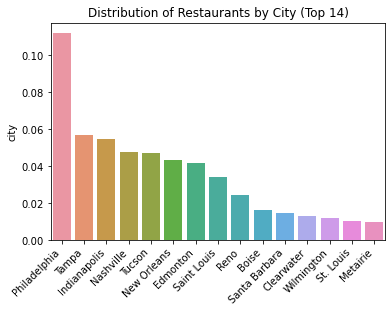

In [37]:
sns.barplot(x=restaurants['city'].value_counts().index.tolist()[:15], y = restaurants['city'].value_counts(normalize=True)[:15])
plt.title('Distribution of Restaurants by City (Top 14)')
plt.xticks(rotation=45, ha='right')
plt.show()

In [38]:
ratio_list = []
names = []

for name, city in restaurants.groupby(['city']):

    if len(city) > 1000: 
        rev_per_rest = sum(city['review_count'])/len(city)
        ratio_list.append(rev_per_rest)
        names.append(name)

sorted_indices = sorted(range(len(ratio_list)), key=lambda k:ratio_list[k], reverse=True)
# print(ratio_list)
# print(sorted_indices)

ratio_list.sort(reverse=True)
sorted_cities = [names[i] for i in sorted_indices]

print(sorted_cities)
print(ratio_list)


['New Orleans', 'Reno', 'Nashville', 'Philadelphia', 'Tampa', 'Tucson', 'Saint Louis', 'Indianapolis', 'Edmonton']
[206.18938053097344, 148.33540372670808, 127.27127447063523, 113.72548684660062, 98.9969604863222, 96.72145748987855, 95.91568955890564, 84.56464011180992, 28.481994459833796]


Now we know that 'New Orleans', 'Reno', 'Nashville', and 'Philadelphia' have the highest number of reviews per restuarant. Lets look into them a bit more.

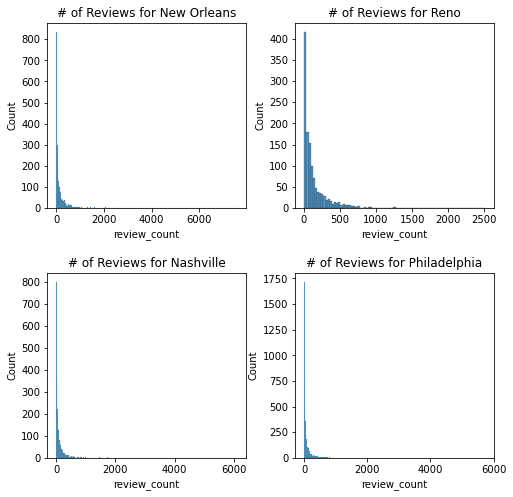

In [39]:
cities_of_interest = ['New Orleans', 'Reno', 'Nashville', 'Philadelphia']
## Looking at distribution of reviews 
fig, axs = plt.subplots(2, 2, figsize=(8,8))
fig.subplots_adjust(hspace = .35, wspace=.25)

for axis, city in zip(axs.ravel(), cities_of_interest):

    df = restaurants.loc[restaurants['city'] == city]
    sns.histplot(ax = axis, data=df['review_count'])
    axis.set_title('# of Reviews for {}'.format(city))

We can see that review counts > 1000 are very sparse for all the cities and that the majority of restaurants have between 0 and 1000 reviews. We can zoom in for more details.

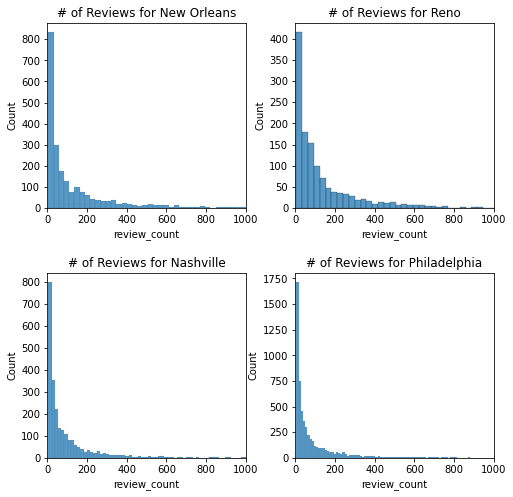

In [40]:
fig, axs = plt.subplots(2, 2, figsize=(8,8))
fig.subplots_adjust(hspace = .35, wspace=.25)

for axis, city in zip(axs.ravel(), cities_of_interest):

    df = restaurants.loc[restaurants['city'] == city]
    sns.histplot(ax = axis, data=df['review_count'])
    axis.set_title('# of Reviews for {}'.format(city))
    axis.set_xlim([0,1000])

In [ ]:
# Separating resturants in New Orleans, Nashville, Philadelphia, and Reno
df_cities_of_interest = restaurants[restaurants['city'].isin(cities_of_interest)]
#df_cities_of_interest.head(5)

cities_of_interest_info = pd.DataFrame()
review_count = []
numb_restaurants = []
names = []

for name, city in df_cities_of_interest.groupby(['city']):
    names.append(name)
    review_count.append(city['review_count'].sum())
    numb_restaurants.append(len(city))

cities_of_interest_info['city'] = names
cities_of_interest_info['total reviews'] = review_count
cities_of_interest_info['numb of resturants'] = numb_restaurants
cities_of_interest_info['rev/bus'] = [review_count[i]/numb_restaurants[i] for i in range(len(names))]
cities_of_interest_info.sort_values(by=['rev/bus'], inplace=True, ascending=False)
cities_of_interest_info


## Reviews

### Initial Insights

The following is based on a subset of the reviews for restaurants in Reno and Nashville 
* 

In [41]:
## loading csv file with all the reviews
reviews = pd.read_csv(path  + 'raw_reviews.csv')
reviews.drop('Unnamed: 0', axis =1, inplace = True)
#reviews.head(5)

Things we are interested in: 
* How many reviews does each restaurant have for a given city 
* What is the most frequent # of reviews
* Are there duplicated reviews? If so, are the ratings the same? How do we handle these? 

In [42]:
# Merge the reviews and restaurants dataframes
merged_df = pd.merge(reviews, restaurants, on='business_id')

# Filter by city
reno_merged_df = merged_df.loc[merged_df['city'] == 'Reno']

In [43]:
path = '/Users/shafz/OneDrive/Documents/machine-learning-dse-i210-final-project-yelprestaurantrecommender/data/processed/'
reno = pd.read_csv(path+'Reno.csv')
reno.drop('Unnamed: 0', axis = 1, inplace=True)
cols = reno.columns.tolist()
idx = cols.index('user_id')
cols = cols[idx:] + cols[:idx]
reno = reno[cols] 
#reno.head(5)

In [44]:
row_vals = np.array(reno.isna().sum(axis=1))
sorted_indices = sorted(range(len(row_vals)), key=lambda k:row_vals[k], reverse=False)
users = reno['user_id'].tolist()
row_vals.sort()
sorted_users = [users for i in sorted_indices][0]


In [ ]:
row_vals = 1289 - row_vals
usable_data = row_vals[row_vals >= 95]
usable_users = sorted_users[row_vals >= 95]
print('len(usable_data): ', len(usable_data))

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(16,4))
sns.histplot(ax=axes[0], data=reno_merged_df['business_id'].value_counts().tolist())
sns.histplot(ax=axes[1], data=reno_merged_df['business_id'].value_counts().tolist())
plt.xlim([0,750])
plt.suptitle('Actual number of reviews for all buisinesses in Reno (in reviews data)')
plt.show()


## Users

### Initial Insights


In [ ]:
users = pd.read_csv(r'C:\Users\shafz\OneDrive\Documents\machine-learning-dse-i210-final-project-yelprestaurantrecommender\data\raw\raw_users.csv')
users.drop('Unnamed: 0', axis =1, inplace = True)
users.head(5)

In [ ]:
print('Users shape: ', users.shape)
print('Columns: ', users.columns)
print('Dtype: ', users.dtypes)